In [1]:
from db_connection import create_connection
from db_connection import query_data
from db_connection import query_sql_file

from preprocessing import process_diagnoses

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Connect to the MIMIC-III database
con = create_connection()

# SERVICES

In [3]:
query = \
"""
SELECT * FROM services;
"""

services = query_data(query, con)
print(services.head())

C:\Users\Perdorues\Documents\GitHub\comp-1252-explain-deep-learning-models-through-fuzzy-logic\db_connection.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql_query(query, con)


   row_id  subject_id  hadm_id        transfertime prev_service curr_service
0     758         471   135879 2122-07-22 14:07:27        TSURG          MED
1     759         471   135879 2122-07-26 18:31:49          MED        TSURG
2     760         472   173064 2172-09-28 19:22:15         None         CMED
3     761         473   129194 2201-01-09 20:16:45         None           NB
4     762         474   194246 2181-03-23 08:24:41         None           NB


In [4]:
services.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73343 entries, 0 to 73342
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   row_id        73343 non-null  int64         
 1   subject_id    73343 non-null  int64         
 2   hadm_id       73343 non-null  int64         
 3   transfertime  73343 non-null  datetime64[ns]
 4   prev_service  14668 non-null  object        
 5   curr_service  73343 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.4+ MB


<Axes: xlabel='count', ylabel='curr_service'>

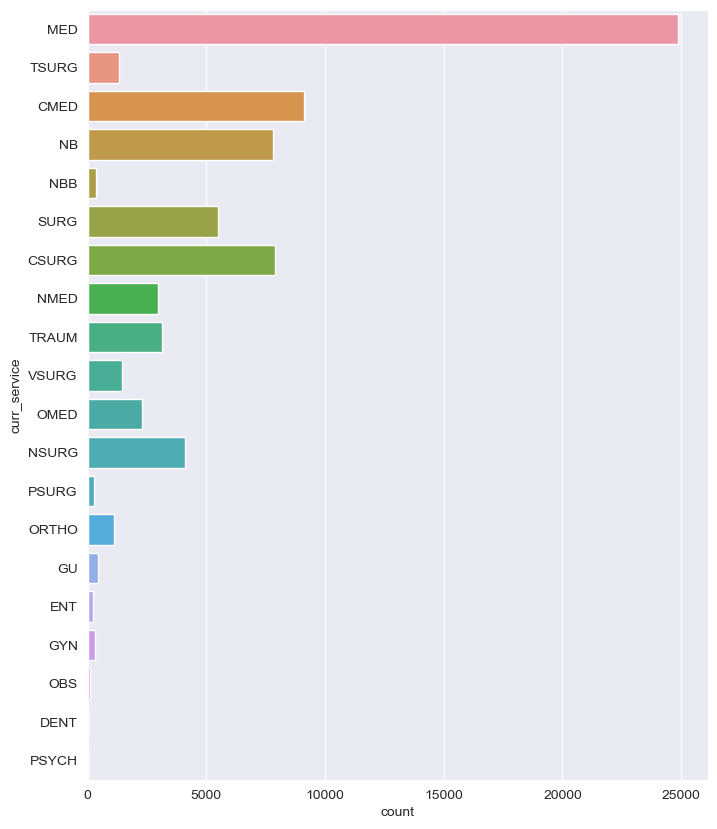

In [5]:
plt.figure(figsize=(8, 10))
sns.countplot(data=services, y='curr_service', orient='h')

# DIAGNOSES

In [6]:
query = """
SELECT d.*, dicd.short_title, dicd.long_title
FROM diagnoses_icd AS d
    JOIN d_icd_diagnoses AS dicd
    ON d.icd9_code = dicd.icd9_code
ORDER BY d.subject_id, d.hadm_id, d.seq_num;
"""

diagnoses = query_data(query, con)
print(diagnoses.head())

C:\Users\Perdorues\Documents\GitHub\comp-1252-explain-deep-learning-models-through-fuzzy-logic\db_connection.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql_query(query, con)


   row_id  subject_id  hadm_id  seq_num icd9_code               short_title  \
0       1           2   163353        1     V3001    Single lb in-hosp w cs   
1       2           2   163353        2      V053  Need prphyl vc vrl hepat   
2       3           2   163353        3      V290    NB obsrv suspct infect   
3       4           3   145834        1      0389            Septicemia NOS   
4       5           3   145834        2     78559      Shock w/o trauma NEC   

                                          long_title  
0  Single liveborn, born in hospital, delivered b...  
1  Need for prophylactic vaccination and inoculat...  
2     Observation for suspected infectious condition  
3                             Unspecified septicemia  
4              Other shock without mention of trauma  


In [7]:
print(diagnoses.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634709 entries, 0 to 634708
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   row_id       634709 non-null  int64 
 1   subject_id   634709 non-null  int64 
 2   hadm_id      634709 non-null  int64 
 3   seq_num      634709 non-null  int64 
 4   icd9_code    634709 non-null  object
 5   short_title  634709 non-null  object
 6   long_title   634709 non-null  object
dtypes: int64(4), object(3)
memory usage: 33.9+ MB
None


In [8]:
query = \
"""
SELECT * FROM admissions;
"""
admissions = query_data(query, con)

C:\Users\Perdorues\Documents\GitHub\comp-1252-explain-deep-learning-models-through-fuzzy-logic\db_connection.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql_query(query, con)


In [9]:
query = \
"""
SELECT a.hadm_id, s.hadm_id AS s_hadm_id
FROM admissions AS a
LEFT JOIN services AS s
ON a.hadm_id = s.hadm_id;
"""

result = query_data(query, con)
missing_services = result[result['s_hadm_id'].isnull()]

print(f"Number of missing HADM_IDs in services: {len(missing_services)}")

Number of missing HADM_IDs in services: 50


C:\Users\Perdorues\Documents\GitHub\comp-1252-explain-deep-learning-models-through-fuzzy-logic\db_connection.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql_query(query, con)


In [10]:
query = """
SELECT a.hadm_id, d.hadm_id AS d_hadm_id
FROM admissions AS a
LEFT JOIN diagnoses_icd AS d
ON a.hadm_id = d.hadm_id;
"""

result = query_data(query, con)
missing_services = result[result['d_hadm_id'].isnull()]

print(f"Number of missing HADM_IDs in diagnoses: {len(missing_services)}")

C:\Users\Perdorues\Documents\GitHub\comp-1252-explain-deep-learning-models-through-fuzzy-logic\db_connection.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result_df = pd.read_sql_query(query, con)


Number of missing HADM_IDs in diagnoses: 0


### Grouping similar diagnoses using services and diagnoses descriptions

In [16]:
# Merge DIAGNOSES_ICD and SERVICES tables based on HADM_ID and SUBJECT_ID
df = pd.merge(diagnoses, services[['hadm_id', 'subject_id', 'curr_service']], on=['hadm_id', 'subject_id'], how='left')
df.head()

,row_id,subject_id,hadm_id,seq_num,icd9_code,short_title,long_title,curr_service
0,1,2,163353,1,V3001,Single lb in-hosp w cs,"Single liveborn, born in hospital, delivered b...",NB
1,2,2,163353,2,V053,Need prphyl vc vrl hepat,Need for prophylactic vaccination and inoculat...,NB
2,3,2,163353,3,V290,NB obsrv suspct infect,Observation for suspected infectious condition,NB
3,4,3,145834,1,0389,Septicemia NOS,Unspecified septicemia,VSURG
4,4,3,145834,1,0389,Septicemia NOS,Unspecified septicemia,MED


In [22]:
print(df[df.curr_service.isnull()])

        row_id  subject_id  hadm_id  seq_num icd9_code  \
10721     8499         736   164142        1     03849   
10722     8500         736   164142        2     99592   
10723     8502         736   164142        4     51881   
10724     8503         736   164142        5      5849   
10725     8504         736   164142        6     57149   
...        ...         ...      ...      ...       ...   
815435  638546       97181   184149        6      5854   
815436  638547       97181   184149        7      4240   
815437  638548       97181   184149        8      4168   
815438  638549       97181   184149        9     41401   
815439  638550       97181   184149       10      4280   

                     short_title  \
10721    Gram-neg septicemia NEC   
10722              Severe sepsis   
10723   Acute respiratry failure   
10724   Acute kidney failure NOS   
10725      Chronic hepatitis NEC   
...                          ...   
815435   Chr kidney dis stage IV   
815436     Mitr

In [13]:
# 1. Group by Service Type
df = df.groupby('curr_service')
print(df.head())

        row_id  subject_id  hadm_id  seq_num icd9_code  \
0            1           2   163353        1     V3001   
1            2           2   163353        2      V053   
2            3           2   163353        3      V290   
3            4           3   145834        1      0389   
4            4           3   145834        1      0389   
...        ...         ...      ...      ...       ...   
57937    47119        4208   147618        4     47829   
57938    47120        4208   147618        5      4786   
446692  362880       31523   188776        2     78039   
446694  362881       31523   188776        3     29623   
446696  362882       31523   188776        4     E9503   

                     short_title  \
0         Single lb in-hosp w cs   
1       Need prphyl vc vrl hepat   
2         NB obsrv suspct infect   
3                 Septicemia NOS   
4                 Septicemia NOS   
...                          ...   
57937     Disease of pharynx NEC   
57938          

In [14]:
# # 2. Within each Service Type group, further cluster based on diagnoses descriptions
#
# import nltk
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.cluster import KMeans
#
#
# for name, group in df:
#     stemmer = nltk.stem.porter.PorterStemmer()
#     tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
#
#     def preprocess(text):
#         tokens = tokenizer.tokenize(text.lower())
#         return ' '.join([stemmer.stem(token) for token in tokens])
#
#     # Preprocess the diagnosis descriptions
#     processed_descriptions = group['diagnosis_description'].apply(preprocess)
#
#     vectorizer = TfidfVectorizer(max_features=1000)
#     tfidf_matrix = vectorizer.fit_transform(processed_descriptions)
#
#     kmeans = KMeans(n_clusters=10)
#     kmeans.fit(tfidf_matrix)
#
#     group['cluster_label'] = kmeans.labels_